In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import h5py

In [2]:
import regressor
import utils

In [3]:
import warnings
warnings.filterwarnings("ignore")

# Utils

In [4]:
def plot_light_curves_with_sigma(t, flux, flux_err, passband, title=""):
    colors = ['C'+str(i) for i in range(len(np.unique(passband)))]
    plt.figure(figsize=(9, 4))
    for i, pb in enumerate(np.unique(passband)):
        plt.plot(t[passband == pb], flux[passband == pb], linewidth=2., color=colors[i])
        plt.fill_between(t[passband == pb], 
                         flux[passband == pb]+1*flux_err[passband == pb], 
                         flux[passband == pb]-1*flux_err[passband == pb], label=passband2name[pb], alpha=0.5, color=colors[i])
    plt.xlabel('Time', size=14)
    plt.xticks(size=14)
    plt.ylabel('Flux', size=14)
    plt.yticks(size=14)
    plt.legend(loc='best', ncol=3, fontsize=14)
    plt.title(title, size=14)

# Data

In [5]:
sigma = 0.2

anobject = pd.DataFrame()
anobject['mjd'] = np.arange(0, 200)
anobject['flux'] = np.sin(anobject['mjd'] / 40) + np.random.normal(0, sigma, len(anobject['mjd']))
anobject['passband'] = [0] * len(anobject['mjd'])
anobject['flux_err'] = [sigma] * len(anobject['mjd'])

passband2name = {0: 'u'}
passband2lam  = {0: np.log10(3751.36)}

In [6]:
t = anobject['mjd'].values
flux = anobject['flux'].values
flux_err = anobject['flux_err'].values
passband = anobject['passband'].values

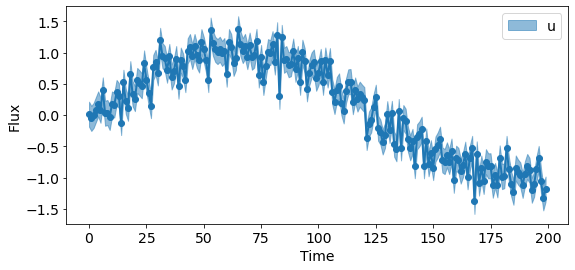

In [7]:
plot_light_curves_with_sigma(t, flux, flux_err, passband, title="")
plt.scatter(t, flux, label='')
plt.legend(loc='best', ncol=3, fontsize=14)

# Train / test split

In [8]:
from binned_split import binned_train_test_split


anobject_train, anobject_test = binned_train_test_split(anobject, 
                                                        t=t, 
                                                        bin_size=20, 
                                                        test_size=5, 
                                                        shuffle=True, 
                                                        random_state=42, 
                                                        bounds_in_train=True)

In [9]:
t_train = anobject_train['mjd'].values
flux_train = anobject_train['flux'].values
flux_err_train = anobject_train['flux_err'].values
passband_train = anobject_train['passband'].values

t_test = anobject_test['mjd'].values
flux_test = anobject_test['flux'].values
flux_err_test = anobject_test['flux_err'].values
passband_test = anobject_test['passband'].values

# Approximation

In [10]:
import fulu

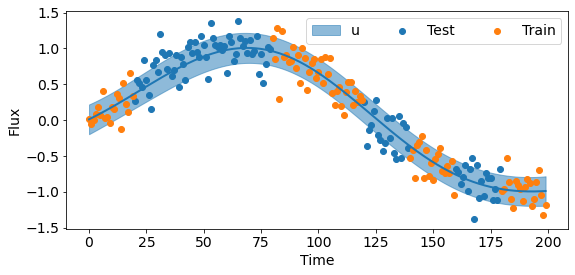

In [11]:
aug = fulu.GaussianProcessesAugmentation(passband2lam)

aug.fit(t_train, flux_train, flux_err_train, passband_train)
t_aug, flux_aug, flux_err_aug, passband_aug= aug.augmentation(t_min=t.min(), t_max=t.max(), n_obs=1000)

plot_light_curves_with_sigma(t_aug, flux_aug, flux_err_aug, passband_aug, title="")
plt.scatter(t_test, flux_test, label='Test')
plt.scatter(t_train, flux_train, label='Train')
plt.legend(loc='best', ncol=3, fontsize=14)

# Prediction on test

In [12]:
flux_pred_test, flux_err_pred_test = aug.predict(t_test, passband_test)

# Quality metrics

In [13]:
# The Negative Log Predictive Density (NLPD) metric calculation.
# Source: http://mlg.eng.cam.ac.uk/pub/pdf/QuiRasSinetal06.pdf

utils.nlpd_metric(flux_test, flux_pred_test, flux_err_pred_test) # меньше лучше

0.837378586692406

In [14]:
# The normalized Root Mean Squared Error (nRMSE) metric. 
# Source: http://mlg.eng.cam.ac.uk/pub/pdf/QuiRasSinetal06.pdf

utils.nrmse_metric(flux_test, flux_err_test, flux_pred_test) # меньше лучше

1.108361074284161

In [15]:
# The Prediction Interval Coverage Probability (PICP) metric. 
# Source: https://www.sciencedirect.com/science/article/pii/S0893608006000153?via%3Dihub

utils.picp_metric(flux_test, flux_pred_test, flux_err_pred_test, alpha=0.9) # ближе к alpha лучше

0.9

In [16]:
# calculate quality metrics
[rmse, mae, rse, rae, mape] = utils.regression_quality_metrics_report(flux_test, flux_pred_test)
print("RMSE: ", rmse)
print("MAE: ", mae)
print("RSE: ", rse)
print("RAE: ", rae)
print("MAPE: ", mape)

RMSE:  0.22167221485683225
MAE:  0.18338640883477267
RSE:  0.2945267172169866
RAE:  0.27461401959253867
MAPE:  58.09783961845919


In [17]:
# calculate quality metrics
[rmse, mae, rse, rae, mape, nlpd, nrmse, picp] = utils.regression_quality_metrics_report(flux_test, flux_pred_test, flux_err_test, flux_err_pred_test, alpha=0.90)

print("RMSE: ", rmse)
print("MAE: ", mae)
print("RSE: ", rse)
print("RAE: ", rae)
print("MAPE: ", mape)
print("NLPD: ", nlpd)
print("nRMSE: ", nrmse)
print("PICP: ", picp)

RMSE:  0.22167221485683225
MAE:  0.18338640883477267
RSE:  0.2945267172169866
RAE:  0.27461401959253867
MAPE:  58.09783961845919
NLPD:  0.837378586692406
nRMSE:  1.108361074284161
PICP:  0.9
